# Классификация древних языков с помощью DenseNet161

In [ ]:
import os
#import numpy as np
from google.colab import files
from fastai import *
from fastai.vision import *
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Загрузка данных

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving ancient.zip to ancient.zip


In [ ]:
!unzip ancient.zip

Archive:  ancient.zip
  inflating: ancient_language_dataset/test/arabic/24dca116894a4de7e530f7f7ffdf5cea--islamic-images-arabic-beauty.jpg  
  inflating: ancient_language_dataset/test/arabic/Calligraphy-Arabic-Font161-min.jpg  
  inflating: ancient_language_dataset/test/arabic/Khirbet-Inscription-Hisham.jpg  
  inflating: ancient_language_dataset/test/arabic/MalDia-04-10-08-16-Abate-Vella-claimed-to-have-discovered-ancient-Arabic-parchments.-751x1024.jpg  
  inflating: ancient_language_dataset/test/arabic/Writing-style-follow-by-Arabic-Script_Q320.jpg  
  inflating: ancient_language_dataset/test/arabic/a31224b.jpg  
  inflating: ancient_language_dataset/test/arabic/epigraphy_ambalangoda_port_des_01.jpg  
  inflating: ancient_language_dataset/test/arabic/istockphoto-183578917-612x612.jpg  
  inflating: ancient_language_dataset/test/arabic/istockphoto-644911038-1024x1024.jpg  
  inflating: ancient_language_dataset/test/egyptian/124388-004-686BFFFF.jpg  
  inflating: ancient_language_data

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4 MB 6.8 kB/s 
     |████████████████████████████████| 4.0 MB 35.2 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.


## Обучение

In [ ]:
bs=16
np.random.seed(2)
os.chdir('/content')

In [ ]:
data_path = "./ancient_language_dataset/"
data = ImageDataBunch.from_folder(data_path, ds_tfms=get_transforms(), size=299, bs=bs, num_workers=0).normalize(imagenet_stats)

In [ ]:
data.c, len(data.train_ds), len(data.valid_ds)

(8, 253, 65)

In [ ]:
help(get_transforms)

Help on function get_transforms in module fastai.vision.transform:

get_transforms(do_flip: bool = True, flip_vert: bool = False, max_rotate: float = 10.0, max_zoom: float = 1.1, max_lighting: float = 0.2, max_warp: float = 0.2, p_affine: float = 0.75, p_lighting: float = 0.75, xtra_tfms: Union[Collection[fastai.vision.image.Transform], NoneType] = None) -> Collection[fastai.vision.image.Transform]
    Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms.



In [ ]:
learn = cnn_learner(data, models.densenet161, metrics=accuracy, path=".")

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

In [ ]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,3.082960,1.696354,0.446154,01:24
1,2.060575,1.359995,0.661538,00:29
2,1.465391,1.097281,0.753846,00:29
3,1.132782,0.960095,0.646154,00:29
4,0.934076,0.717104,0.815385,00:29
5,0.748116,0.788076,0.784615,00:29
6,0.615772,0.844629,0.753846,00:29
7,0.498602,0.864507,0.753846,00:28
8,0.402938,0.795283,0.769231,00:28
9,0.350071,0.832157,0.769231,00:29


In [ ]:
learn.save('stage-1')

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


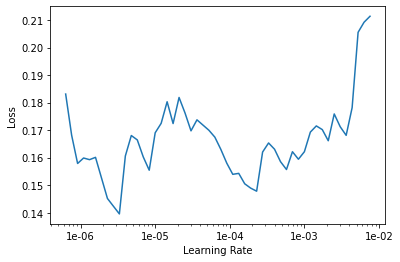

In [ ]:
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4,max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.180001,0.770748,0.784615,00:51
1,0.187541,0.840470,0.800000,00:34
2,0.142178,0.819146,0.830769,00:34
3,0.113990,0.800907,0.830769,00:34


In [ ]:
learn.save('stage-2')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs=interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

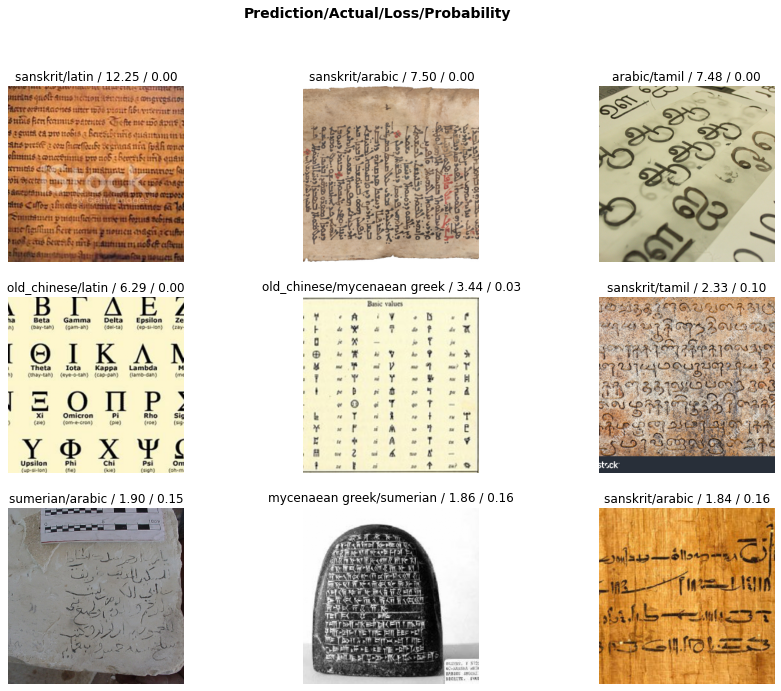

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

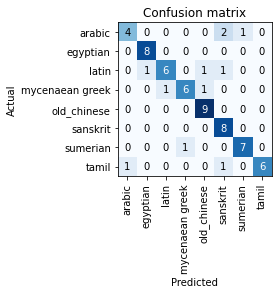

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused(min_val=1)

[('arabic', 'sanskrit', 2),
 ('arabic', 'sumerian', 1),
 ('latin', 'egyptian', 1),
 ('latin', 'old_chinese', 1),
 ('latin', 'sanskrit', 1),
 ('mycenaean greek', 'latin', 1),
 ('mycenaean greek', 'old_chinese', 1),
 ('sumerian', 'mycenaean greek', 1),
 ('tamil', 'arabic', 1),
 ('tamil', 'sanskrit', 1)]

In [ ]:
precision = 0
recall = 0
for i in range(0, 7):
  s = 0
  for j in range(0, 7):
    s += interp.confusion_matrix()[i][j]
  precision_i = interp.confusion_matrix()[i][i] / s
  precision += precision_i
  s = 0
  for j in range(0, 7):
    s += interp.confusion_matrix()[j][i]
  recall_i = interp.confusion_matrix()[i][i] / s
  recall += recall_i

precision = precision / 8
recall = recall / 8
print(precision, recall)

0.7328869047619048 0.7529536435786436


In [ ]:
f1score = 2 * (precision * recall) / (precision + recall)
f1score

0.7427847703952598

In [ ]:
num = 0
denom = 0
for i in range(0, 7):
  num += interp.confusion_matrix()[i][i]
  for j in range(0, 7):
    denom += interp.confusion_matrix()[i][j]

acc = num / denom
acc

0.8421052631578947